# Thermal Neural Networks (Tensorflow 2 example)

This jupyter notebook showcases how to utilize a thermal neural network (TNN) on an exemplary data set.

This notebook makes heavy use of scripts from the "aux" package in this repository.

For a more concise example refer to the pytorch example notebook.

## Get the Data Set
The data set can be downloaded from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature).
It should be placed in `data/input/`.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

from aux import config as cfg
from aux.file_utils import catchtime, Report
from aux.data import LightDataManager
from aux.rnn_model import RNNKerasRegressor, IntegratorStateResetter, NaNCatcher
from aux.lptn_model import build_lptn, ConfigurableTNNCell

### Prepare data

In [2]:
dm = LightDataManager(cfg.data_cfg['file_path'], standardize='simple')
dm.featurize(create_ewmas=False, drop_dq=True)
x_train = dm.tra_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_train = dm.tra_df[dm.y_cols + [dm.PROFILE_ID_COL]]
x_val = dm.val_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_val = dm.val_df[dm.y_cols + [dm.PROFILE_ID_COL]]
x_tst = dm.tst_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_tst = dm.tst_orig_targets

build dataset ..
57.11 MB with 5 input features


### Prepare model config

In [3]:
lr = cfg.keras_cfg['rnn_params']['lr_rate']
stateresetter = IntegratorStateResetter(dm)
callbacks = [stateresetter,
             NaNCatcher(),
             EarlyStopping(min_delta=3e-4, patience=50,
                           verbose=1, restore_best_weights=True),
             ReduceLROnPlateau(min_delta=1e-4,
                               factor=0.9, patience=20, verbose=1,
                               min_lr= lr/ 100),
             ]

batch_size = dm.tra_df.groupby(dm.PROFILE_ID_COL).ngroups
tbptt_len = cfg.keras_cfg['tbptt_len']

# drop thermal conductances optionally like this:
drop_g_tags = [("pm", "stator_yoke"),  # each pair denotes one thermal conductance
               ("pm", "stator_tooth"),
               ("pm", "stator_winding"),
               ("stator_winding", "ambient"),
               ("stator_winding", "coolant"),
               ('ambient', 'coolant')]
drop_g = [(cfg.data_cfg['temperature_cols'].index(i),
           cfg.data_cfg['temperature_cols'].index(j)) for
          i, j in drop_g_tags]

KerasRegressor_config = {'x_shape': (batch_size, tbptt_len, len(dm.x_cols)),  # no degree of freedom here for stateful RNN in keras
                         'verbose': 1,
                         'loss': dm.loss_func,
                         'x_cols': dm.x_cols,
                         'cell_cls': ConfigurableTNNCell,
                         'lr': lr,
                         'optimizer_cls': 'nadam',
                         'p_is_branchful': False,
                         'drop_g': None,  # do not drop thermal conductances
                         'layer_cfg': cfg.keras_cfg['tnn_params']['layer_cfg']
                         }
n_epochs = cfg.keras_cfg['rnn_params']['epochs']
fit_cfg = {'batch_size': batch_size,
           'validation_data': (x_val, y_val),
           'epochs': n_epochs,
           'shuffle': False,
           'tbptt_len': tbptt_len,
           'callbacks': callbacks,
           }
predict_cfg = {k: fit_cfg[k] for k in ['batch_size', 'tbptt_len']}

### Helper functions

In [4]:
def score_model(result_, x_eval, y_eval):
    yhat_te = result_.model.predict(x_eval, val_mode=True)
    result_.yhat_te = dm.inverse_transform(yhat_te)  # convert to DF
    result_.actual = y_eval
    result_.score, _ = dm.score(result_.yhat_te, result_.actual)
    return result_

### Train and evaluate a couple of TNNs

In [5]:
results = []
for i in range(3):
    report = Report(seed=2021+i)
    est = RNNKerasRegressor(build_fn=build_lptn, predict_params=predict_cfg, **KerasRegressor_config)
    est.model = est.build_fn(**KerasRegressor_config)
    with catchtime() as dur:
        _ = est.fit(x=x_train, y=y_train, **fit_cfg)
        report.model = est
        report = score_model(report, x_tst, y_tst)
        report.print()
    print(f'Error backprop + scoring took {float(dur)/60:.2f} mins')
    results.append(report)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(62, 1227, 5)]           0         
_________________________________________________________________
rnn (RNN)                    (62, 1227, 4)             297       
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
36/36 [==============================] - 12s 305ms/step - loss: 0.0323 - val_loss: 0.0119
Epoch 2/120
36/36 [==============================] - 11s 294ms/step - loss: 0.0237 - val_loss: 0.0092
Epoch 3/120
36/36 [==============================] - 10s 292ms/step - loss: 0.0162 - val_loss: 0.0064
Epoch 4/120
36/36 [==============================] - 10s 292ms/step - loss: 0.0112 - val_loss: 0.0040
Epoch 5/120
36/36 [==============================] - 10s 290ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 6/120
36/

Epoch 71/120
36/36 [==============================] - 10s 279ms/step - loss: 4.8102e-04 - val_loss: 2.6969e-04
Epoch 72/120
36/36 [==============================] - 10s 291ms/step - loss: 4.7378e-04 - val_loss: 2.6684e-04
Epoch 73/120
36/36 [==============================] - 10s 287ms/step - loss: 4.6665e-04 - val_loss: 2.6400e-04
Epoch 74/120
36/36 [==============================] - 10s 286ms/step - loss: 4.5965e-04 - val_loss: 2.6117e-04
Epoch 75/120
36/36 [==============================] - 10s 284ms/step - loss: 4.5276e-04 - val_loss: 2.5834e-04
Epoch 76/120
36/36 [==============================] - 10s 278ms/step - loss: 4.4601e-04 - val_loss: 2.5553e-04
Epoch 77/120
36/36 [==============================] - 10s 283ms/step - loss: 4.3936e-04 - val_loss: 2.5273e-04
Epoch 78/120
36/36 [==============================] - 10s 282ms/step - loss: 4.3283e-04 - val_loss: 2.4996e-04
Epoch 79/120
36/36 [==============================] - 10s 282ms/step - loss: 4.2640e-04 - val_loss: 2.4719e-04
E

36/36 [==============================] - 10s 281ms/step - loss: 7.5902e-04 - val_loss: 4.3632e-04
Epoch 22/120
36/36 [==============================] - 10s 283ms/step - loss: 7.1433e-04 - val_loss: 4.2329e-04
Epoch 23/120
36/36 [==============================] - 10s 284ms/step - loss: 6.7367e-04 - val_loss: 4.1096e-04
Epoch 24/120
36/36 [==============================] - 10s 285ms/step - loss: 6.3559e-04 - val_loss: 3.9936e-04
Epoch 25/120
36/36 [==============================] - 10s 281ms/step - loss: 5.9843e-04 - val_loss: 3.8842e-04
Epoch 26/120
36/36 [==============================] - 10s 282ms/step - loss: 5.6264e-04 - val_loss: 3.7828e-04
Epoch 27/120
36/36 [==============================] - 10s 280ms/step - loss: 5.5172e-04 - val_loss: 3.7071e-04
Epoch 28/120
36/36 [==============================] - 10s 284ms/step - loss: 6.3028e-04 - val_loss: 3.7005e-04
Epoch 29/120
36/36 [==============================] - 10s 278ms/step - loss: 6.0332e-04 - val_loss: 3.6146e-04
Epoch 30/120
3

36/36 [==============================] - 10s 280ms/step - loss: 0.0017 - val_loss: 5.5807e-04
Epoch 21/120
36/36 [==============================] - 10s 276ms/step - loss: 0.0016 - val_loss: 5.2817e-04
Epoch 22/120
36/36 [==============================] - 10s 278ms/step - loss: 0.0016 - val_loss: 4.9982e-04
Epoch 23/120
36/36 [==============================] - 10s 278ms/step - loss: 0.0015 - val_loss: 4.7290e-04
Epoch 24/120
36/36 [==============================] - 10s 278ms/step - loss: 0.0014 - val_loss: 4.4723e-04
Epoch 25/120
36/36 [==============================] - 10s 280ms/step - loss: 0.0014 - val_loss: 4.2265e-04
Epoch 26/120
36/36 [==============================] - 10s 279ms/step - loss: 0.0013 - val_loss: 4.0057e-04
Epoch 27/120
36/36 [==============================] - 10s 277ms/step - loss: 0.0013 - val_loss: 3.8244e-04
Epoch 28/120
36/36 [==============================] - 10s 281ms/step - loss: 0.0012 - val_loss: 3.6719e-04
Epoch 29/120
36/36 [==============================

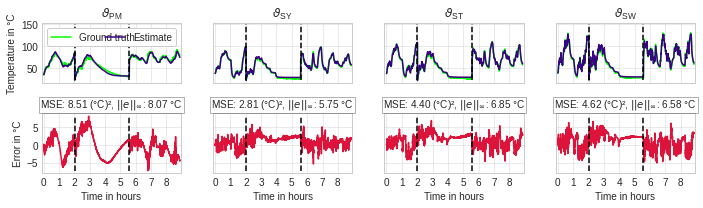

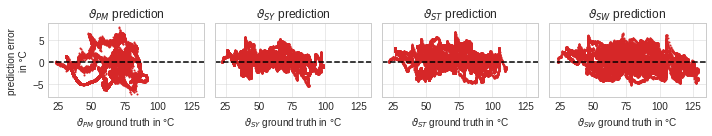

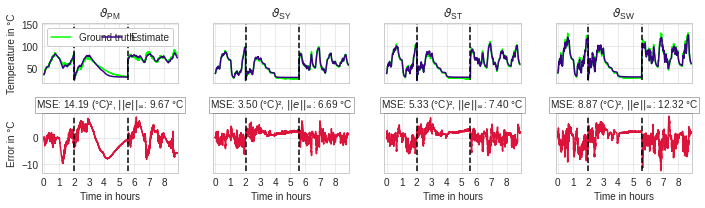

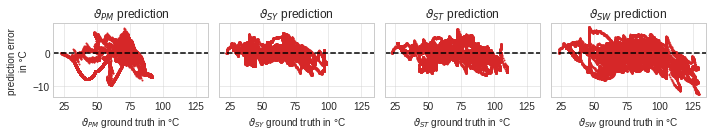

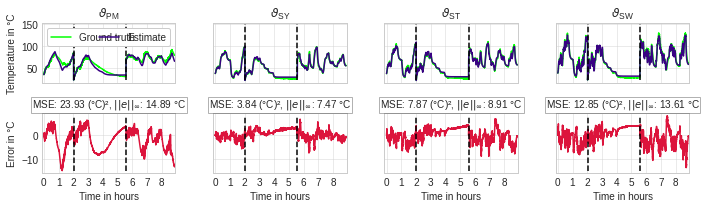

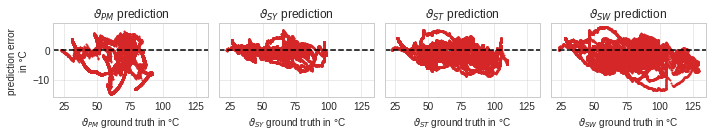

In [6]:
for r in results:
    r.plot(show=False)